In [138]:
import numpy as np
import torch
from torch import nn
import LightPipes as lp
import matplotlib.pyplot as plt
from modes.vortex import Vortex
from modes.zernike import Zernike
from modes.pixel import Pixel
from modes.functions import *
from modes.affinemodel import AffineTransformModel


from sklearn import linear_model

device = 'cuda:3'


truncate_circle = False

Load the Modes and the derivatives

In [139]:
microlens = 20 #20x20
size = microlens

n_zernike = 10

x = torch.linspace(-1,1,size)
y = torch.linspace(-1,1,size)

xx, yy = torch.meshgrid(x,y)

Make a custom wavefront...

Text(0.5, 1.0, 'True Wavefront')

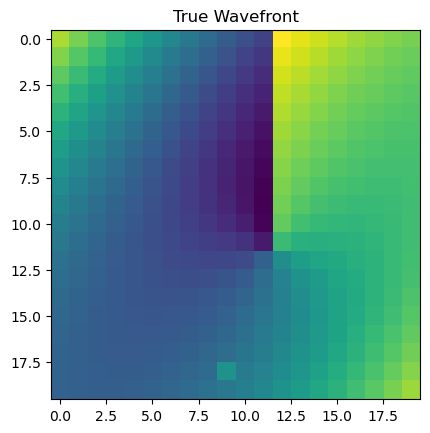

In [445]:
wavefront = torch.zeros(size,size)

decenter = [0.2,0.2]

modes, mode_derivs = get_modes_and_derivs(decenter, xx, yy, n_zernike=n_zernike, truncate_circle=False, pixel_basis = True)

mode_coeffs = torch.zeros((len(modes),1,1))


elements = np.arange(n_zernike)
np.random.shuffle(elements)
elements = elements[:2]
zer_coeffs = torch.rand(len(elements),1,1)

mode_coeffs[elements] = zer_coeffs

mode_coeffs[n_zernike] = 1 #vortex

mode_coeffs[380] = 1

wavefront = torch.sum(mode_coeffs * modes,dim=0)
wavefront_deriv = torch.sum(mode_coeffs * mode_derivs,dim=1)



plt.imshow(wavefront); plt.title('True Wavefront')

In [446]:
mode_derivs.shape

torch.Size([2, 411, 20, 20])

In [447]:
wavefront_deriv.mean()

tensor(-0.0874)

## From here I show once we have gradients


In [448]:
sampled_gradient = wavefront_deriv

mode_gradients = get_mode_derivs([0,0], xx, yy, n_zernike=n_zernike, truncate_circle=False, pixel_basis=False)

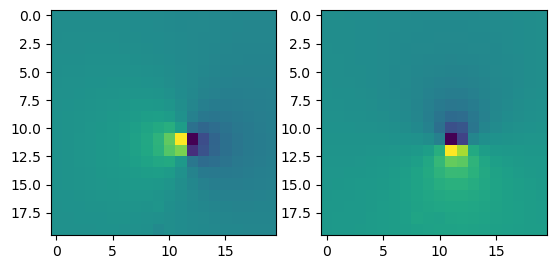

In [449]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(sampled_gradient[0])
ax[1].imshow(sampled_gradient[1])

In [450]:
sampled_gradient[:,10,10] = np.nan
t = sampled_gradient.reshape(-1,1)
u = mode_gradients.permute(0,2,3,1).reshape(-1,mode_gradients.shape[1])

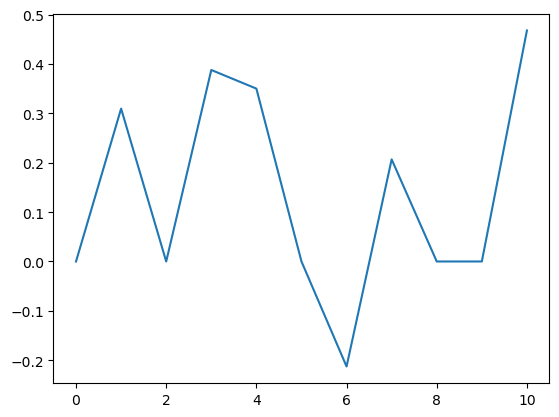

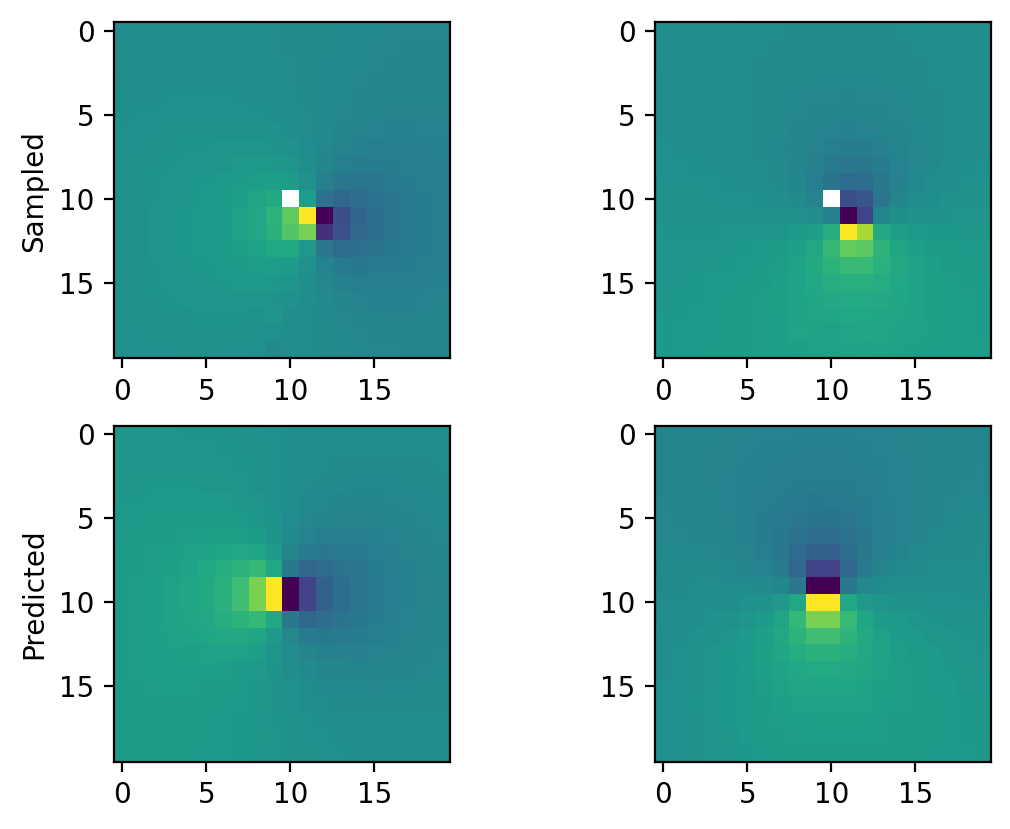

In [451]:

wavefront_grad_prediction, result_vector = LassoFit(sampled_gradient, mode_gradients, alpha=0.01)
plt.figure()
plt.plot(result_vector)


fig,ax = plt.subplots(2,2,dpi=200)
ax[0,0].imshow(sampled_gradient[0]); ax[0,0].set_ylabel('Sampled')
ax[0,1].imshow(sampled_gradient[1])
ax[1,0].imshow(wavefront_grad_prediction[0]); ax[1,0].set_ylabel('Predicted')
ax[1,1].imshow(wavefront_grad_prediction[1])
